# Isolation Forest

In [1]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
all_data = pd.read_csv('surus_4_hepsi.txt', delimiter='\t')
data = all_data.drop(['Saat ', 'dak.', 'san.', 'ms'], axis=1)

In [3]:
clf = IsolationForest(random_state=0).fit(data)

In [4]:
score = clf.decision_function(data)

Text(0.5, 1.0, 'Abomaly Scores')

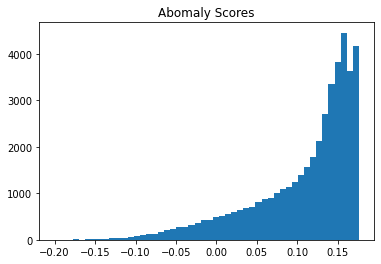

In [5]:
plt.hist(score, bins=50);
plt.title('Abomaly Scores')

In [6]:
results = all_data.copy()

In [7]:
results['anomaly'] = clf.predict(data)

In [8]:
results['anomaly score'] = clf.decision_function(data)

In [9]:
results.query('anomaly == -1').sort_values(by='anomaly score').head()

,Saat,dak.,san.,ms,Vx,Acx,Acy,Acz,Gyx,Gyy,Gyz,Jx,Jy,Jz,Angx,Angy,Angz,anomaly,anomaly score
18675,15,22,16,933800,5.277778,-1314.985788,4822.627844,24669.138026,-1914.655685,-334.900326,-1446.023478,1753.531671,-1581.557391,-5552.310301,11.772638,-491.655228,164.936304,-1,-0.200093
18673,15,22,16,933700,5.277778,782.590217,2005.165057,19959.269937,117.623518,775.794541,-1493.546929,-1861.837249,2798.556359,5244.325250,-835.342942,-408.881574,-123.090519,-1,-0.183825
27523,15,29,38,1376200,19.565851,-4547.490802,-3738.676712,20119.791795,-332.494624,199.854637,-2005.773698,-1162.068450,775.622710,3779.158298,258.642752,-620.484548,154.739086,-1,-0.180304
27662,15,29,45,1383150,23.611111,-3999.982510,2713.702560,22162.353971,-1639.812687,80.053628,1253.621473,936.709997,-1283.414828,-3265.333712,244.508601,-288.048198,46.279195,-1,-0.179799
27658,15,29,45,1382950,23.611111,-611.176913,983.723285,13731.056514,373.546065,969.181359,1293.850645,-1951.962012,3685.494534,2913.586292,-504.778461,247.223103,-73.609236,-1,-0.176973


<AxesSubplot:xlabel='Acx', ylabel='Vx'>

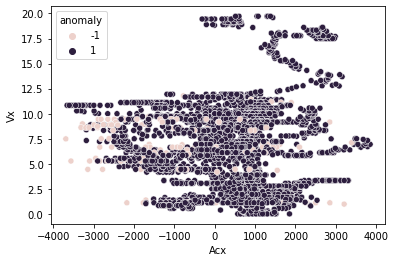

In [10]:
data['anomaly'] = clf.predict(data)
sns.scatterplot(data=data[:5000], x="Acx", y="Vx", hue="anomaly")

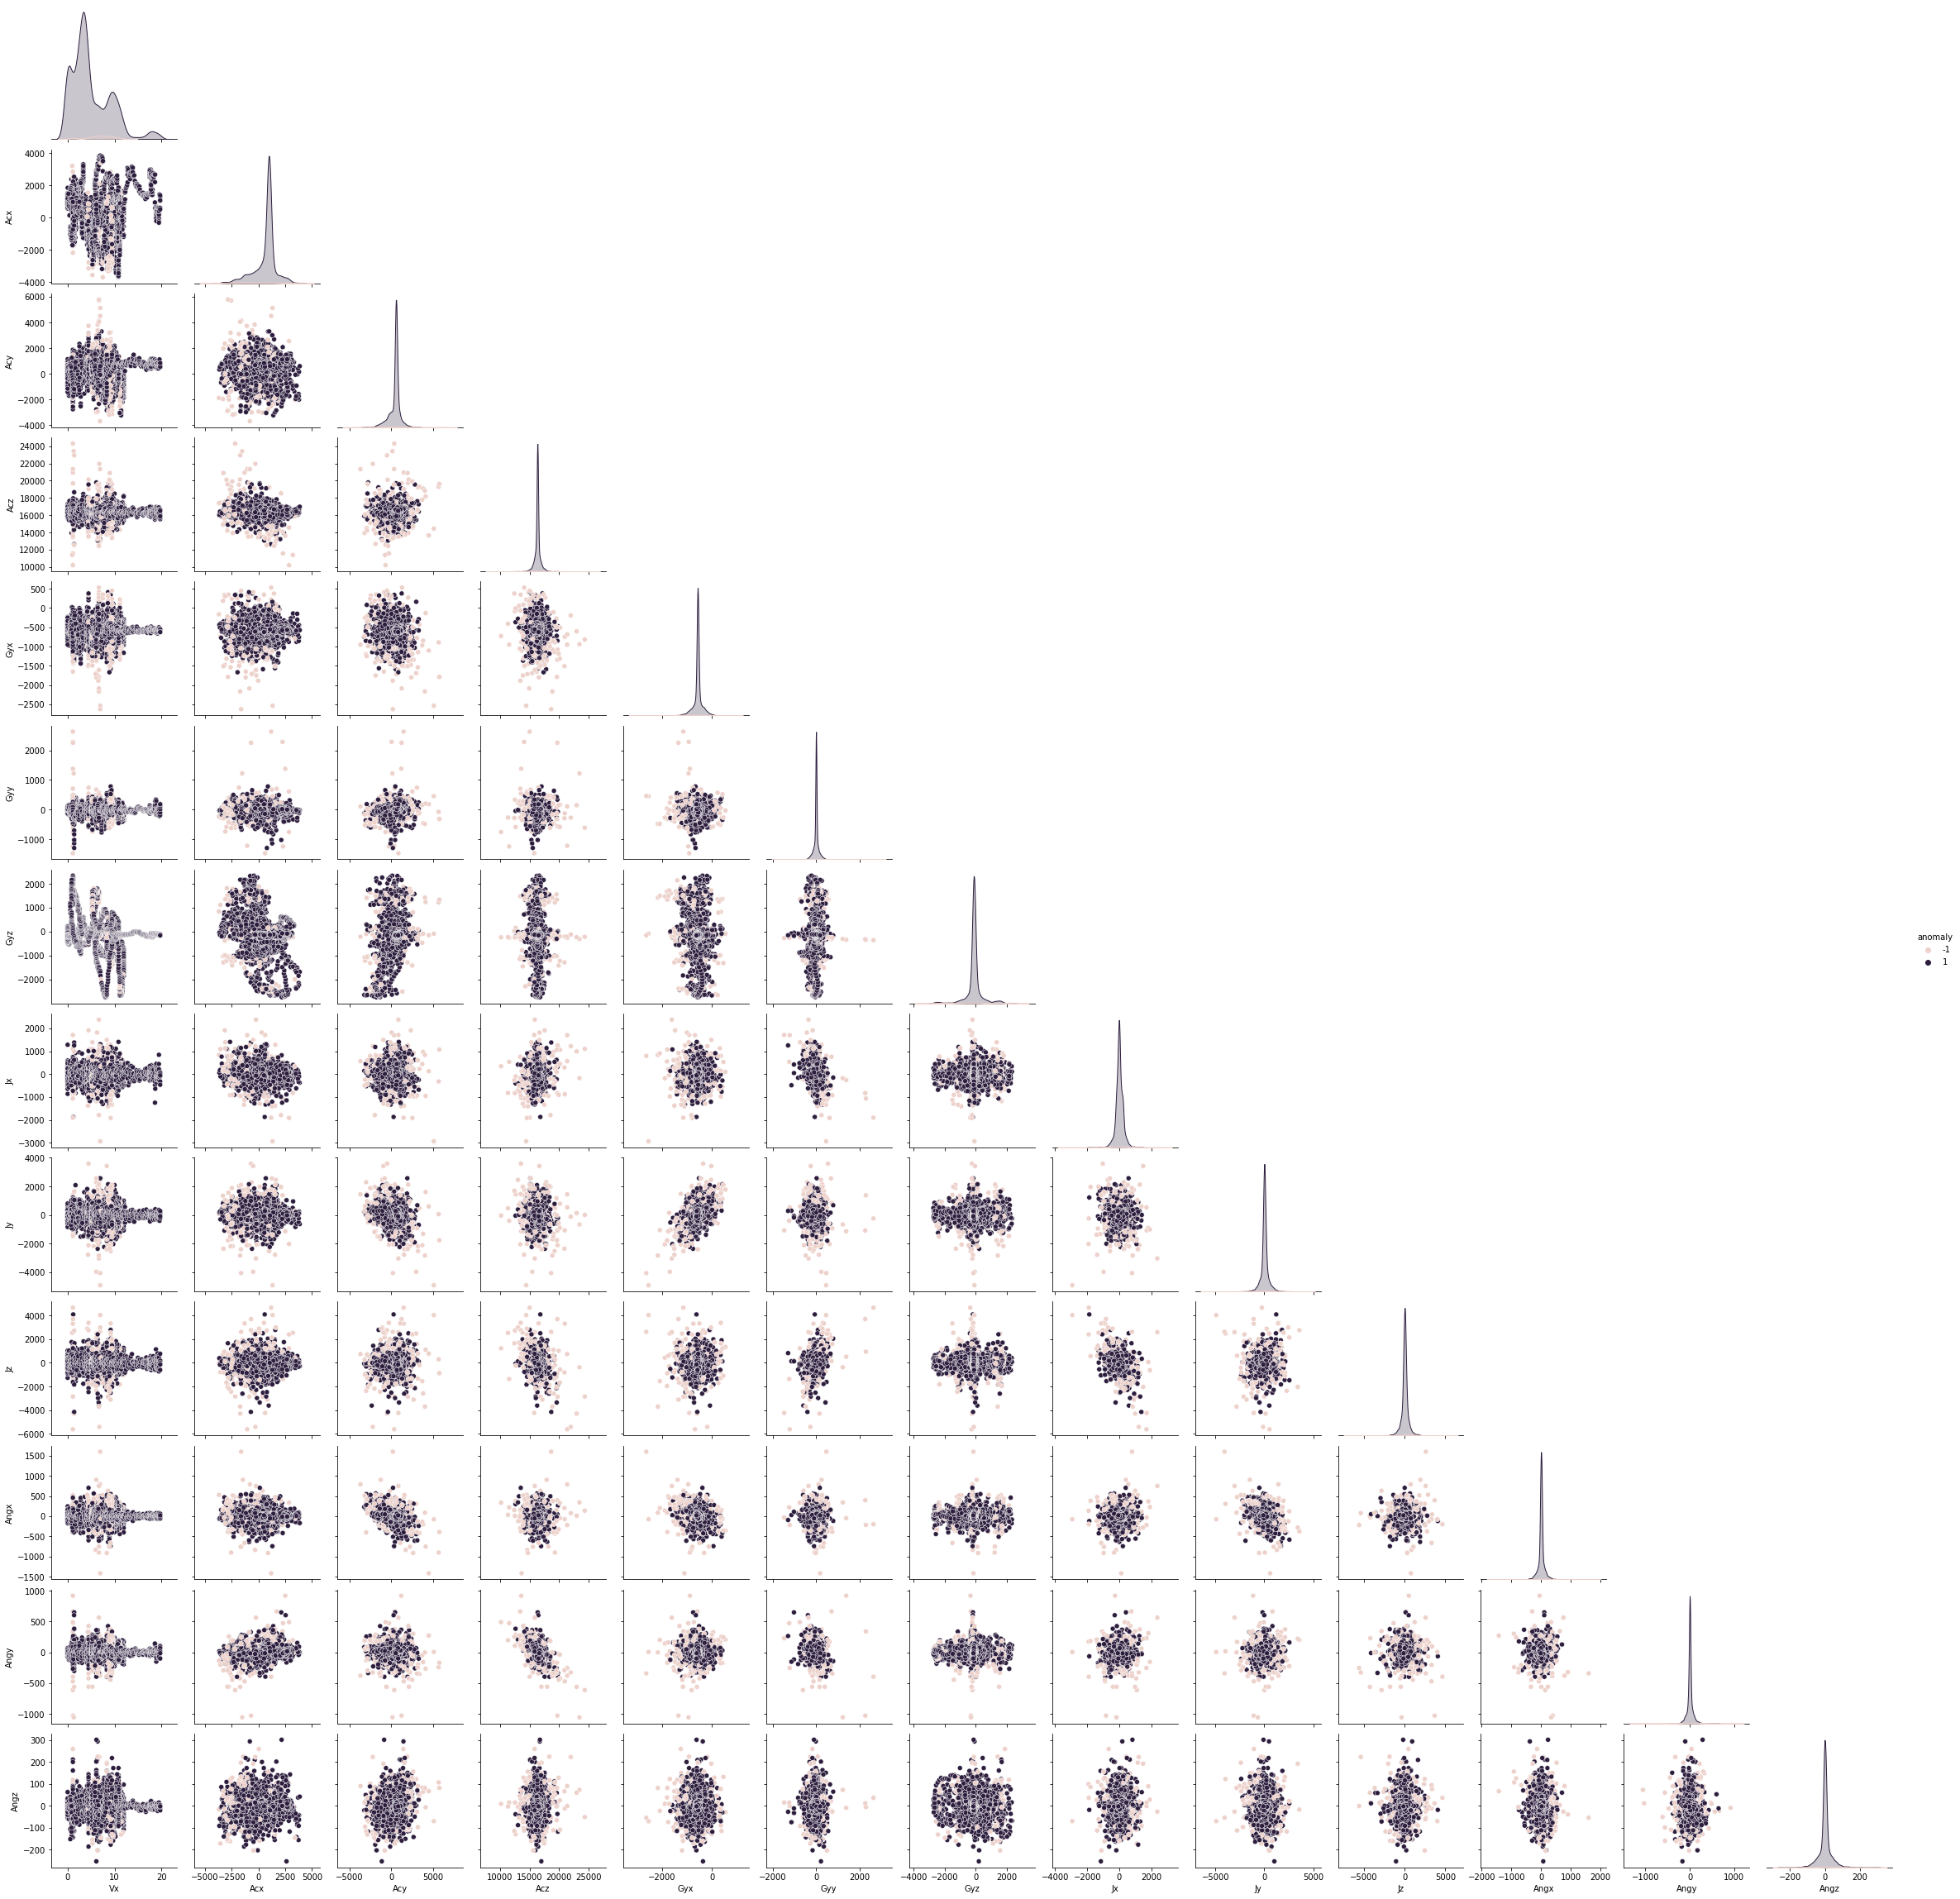

In [11]:
sns.pairplot(data[:5000], hue='anomaly', corner=True);

# AutoEncoder

In [12]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler  

In [13]:
data = pd.read_csv('datasets/surus_4_hepsi.txt', delimiter='\t')
data.drop(['Saat ', 'dak.', 'san.', 'ms'], axis=1, inplace=True)

In [14]:
scaler = MinMaxScaler()
scaler.fit(data)
scaled_data = scaler.transform(data)

In [15]:
x_train, x_test = train_test_split(
        scaled_data, test_size=0.15, random_state=42)

In [16]:
class AutoEncoder(Model):
        def __init__(self):
                super(AutoEncoder, self).__init__()
                self.encoder = tf.keras.Sequential([
                    tf.keras.layers.Dense(128, activation="relu"),
                    tf.keras.layers.Dense(64, activation="relu"),
                    tf.keras.layers.Dense(32, activation="relu"),
                    tf.keras.layers.Dense(16, activation="relu"),
                    tf.keras.layers.Dense(8, activation="relu")
                     ])
            
                self.decoder = tf.keras.Sequential([
                    tf.keras.layers.Dense(16, activation="relu"),
                    tf.keras.layers.Dense(32, activation="relu"),
                    tf.keras.layers.Dense(64, activation="relu"),
                    tf.keras.layers.Dense(128, activation="relu"),
                    tf.keras.layers.Dense(13, activation="sigmoid")])

        def call(self, x):
                encoded = self.encoder(x)
                decoded = self.decoder(encoded)
                return decoded

model = AutoEncoder()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')
model.compile(optimizer='adam', loss='mae')
history = model.fit(x_train, x_train, 
                        epochs=100, batch_size=64, 
                        validation_data = (x_test,x_test), 
                        shuffle=True, callbacks=[early_stopping], verbose=0)

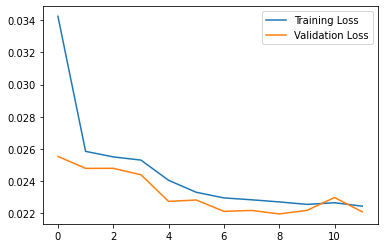

In [17]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

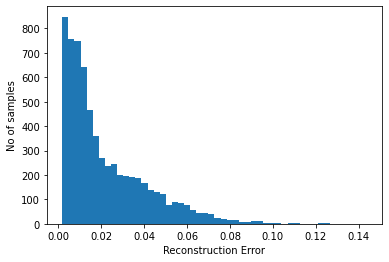

In [18]:
df_test_pred = model.predict(x_test)
test_loss = np.mean(np.abs(df_test_pred - x_test), axis=1)

plt.hist(test_loss, bins=50)
plt.xlabel("Reconstruction Error")
plt.ylabel("No of samples")
plt.show()

In [19]:
#print anomalies location in the test dataset
df_test = pd.DataFrame(x_test)
df_test['scores'] = test_loss
anomalies = df_test.query('scores>0.12')

df_test_pred = pd.DataFrame(df_test_pred)


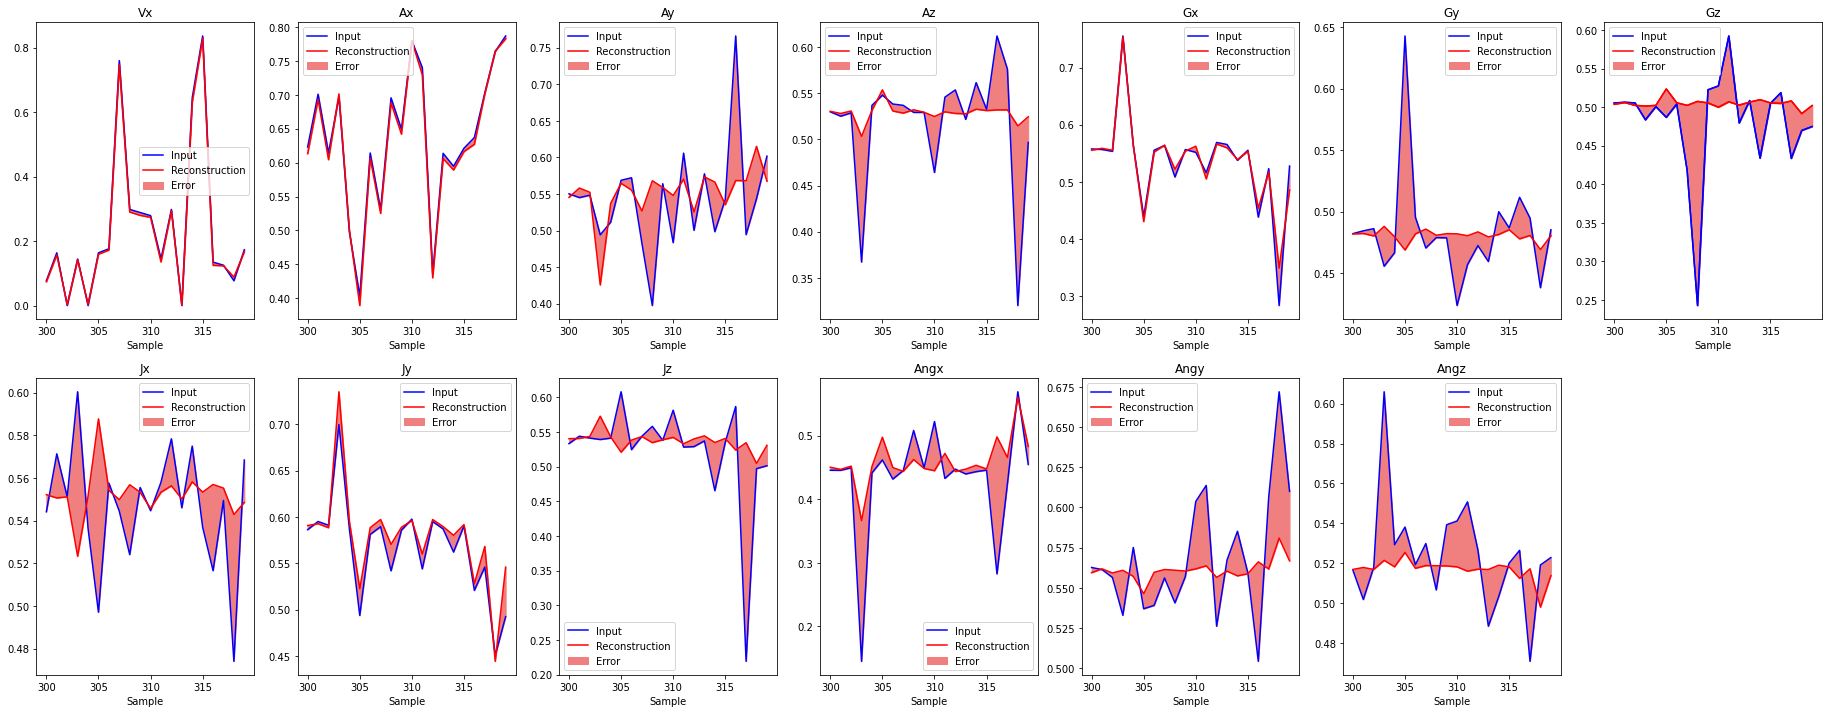

In [20]:
plt.figure(figsize=(32,12))
alt_limit = 300
ust_limit = 320
labels = ['Vx', 'Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz', 'Jx' ,'Jy', 'Jz', 'Angx', 'Angy', 'Angz']
for i in range(7):
    plt.subplot(2,7,i+1)
    plt.plot(df_test.iloc[alt_limit:ust_limit, i], 'b')  
    plt.xlabel('Sample') 
    plt.title(labels[i])
    #plt.ylabel(labels[i])  
    plt.plot(df_test_pred.iloc[alt_limit:ust_limit, i], 'r')
    plt.fill_between(np.arange(alt_limit,ust_limit), df_test_pred.iloc[alt_limit:ust_limit ,i], df_test.iloc[alt_limit:ust_limit ,i], color='lightcoral')
    plt.legend(labels=["Input", "Reconstruction", "Error"])
    plt.subplot(2,7,i+7)
    plt.plot(df_test.iloc[alt_limit:ust_limit, i+6], 'b')     
    plt.xlabel('Sample') 
    plt.title(labels[i+6]) 
    plt.plot(df_test_pred.iloc[alt_limit:ust_limit, i+6], 'r')
    plt.fill_between(np.arange(alt_limit,ust_limit), df_test_pred.iloc[alt_limit:ust_limit, i+6], df_test.iloc[alt_limit:ust_limit, i+6], color='lightcoral')
    plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()